In [1]:
import numpy as np
import sys
import os

from pathlib import Path
import importlib
import utilities as us
importlib.reload(us)

# Add parent directory (where pygestalt lives) to sys.path
sys.path.append(os.path.abspath(".."))

import pygestalt as gs
from pygestalt import sampler

from matplotlib import pyplot as plt
from matplotlib.pyplot import *

import torch
import torch.nn as nn

In [2]:
kernel_tensor_1, angles = us.make_gabor_kernels(ksize=7, sigma=2, lam=4)
kernel_tensor_2, _ = us.make_gabor_kernels(ksize=31, sigma=5, lam=15)

print(angles)

[0.         0.15707963 0.31415927 0.4712389  0.62831853 0.78539816
 0.9424778  1.09955743 1.25663706 1.41371669 1.57079633 1.72787596
 1.88495559 2.04203522 2.19911486 2.35619449 2.51327412 2.67035376
 2.82743339 2.98451302]


In [10]:
outdir = Path(os.getcwd()) / 'outputs'
os.makedirs(outdir, exist_ok=True)

#Ps = np.random.uniform(size=(4,2))
#Ps = np.vstack([[0.2,0], Ps, [0.8,1]])
Ps = np.array([[0.,0.], [0.1,0.9], [0.9,0.1], [1.,1.]])
#Ps = np.array([[0.,0.], [1.,1.]])

radius = 0.02
thresh = 1e-3

%time C, H = sampler.draw_positions(radius, sampler.bezier_curve(Ps), thresh=thresh)
%time D, _ = sampler.draw_positions(radius, sampler.box(), exclusions=C, thresh=thresh)

CPU times: user 3.4 s, sys: 40.6 ms, total: 3.44 s
Wall time: 3.45 s
CPU times: user 19.1 s, sys: 158 ms, total: 19.3 s
Wall time: 19.8 s


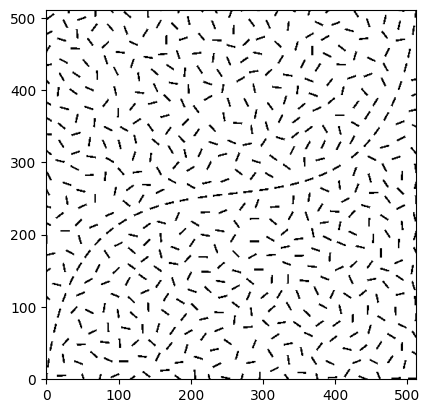

In [11]:
# Define the patch function

l=0.025
w=0.005
pfunc = lambda z,h: gs.patch.segment(z, h, l, w)

N = 512
If, Tf = gs.patch.generate_image(C, H, N=N, pfunc=pfunc)
Ig, Tg = gs.patch.generate_image(D, N=N, pfunc=pfunc)

I = If + Ig

image = torch.tensor(Ig)
image_tensor = image.unsqueeze(0).unsqueeze(0)

image_tensor = image_tensor.to(torch.float32)
kernel_tensor_1 = kernel_tensor_1.to(torch.float32)
kernel_tensor_2 = kernel_tensor_2.to(torch.float32)

plt.imshow(I, aspect='equal',origin= "lower", cmap='binary')

In [12]:
conv1 = nn.functional.conv2d(image_tensor, kernel_tensor_1, stride=1, padding=3)
output = nn.functional.conv2d(conv1, kernel_tensor_2, stride=1, padding=15, groups= 20)

print(conv1.shape)
print(output.shape)

torch.Size([1, 20, 512, 512])
torch.Size([1, 20, 512, 512])


In [13]:
val, channel, x, y = us.cluster(output)
weak_channel, lowest_val = us.weakest_channel(output, x, y)
close_x, close_y = us.find_closest(Ig, x, y)
line = us.find_connected(Ig, close_x, close_y)
outline = us.bounding_square(line)

print(outline)
print(channel)
print(weak_channel)

[(301, 417), (314, 430), 9]
15
18


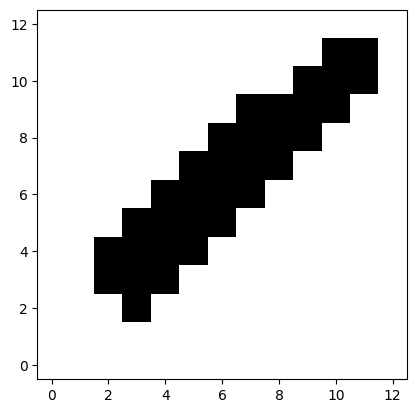

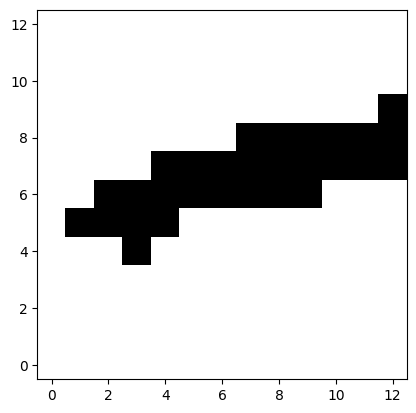

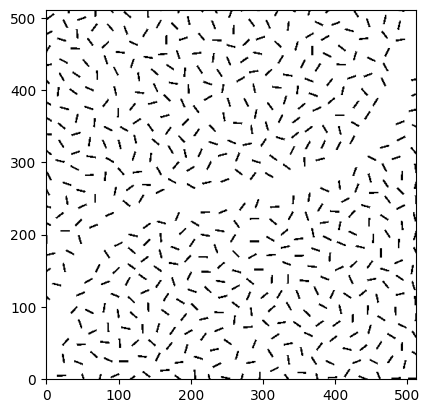

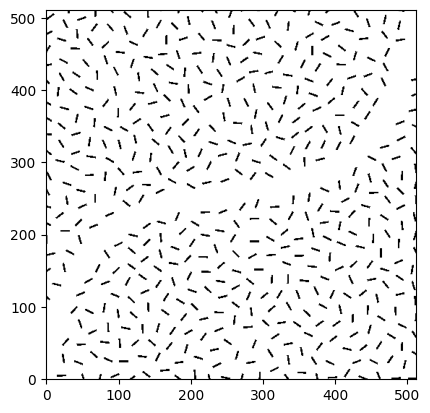

In [14]:
newIg = Ig.copy()

x0, y0 = outline[0]
x1, y1 = outline[1]
sub = Ig[y0:y1, x0:x1].copy()

rotation_angle = angles[weak_channel] - angles[channel]

plt.imshow(sub, aspect='equal', origin='lower', cmap='binary')
plt.show()

# Rotate patch and keep same size
new = us.rotate_img(sub, rotation_angle)

plt.imshow(new, aspect='equal', origin='lower', cmap='binary')
plt.show()

newIg[y0:y1, x0:x1] = new

plt.imshow(Ig, aspect='equal', origin='lower', cmap='binary')
plt.show()

plt.imshow(newIg, aspect='equal', origin='lower', cmap='binary')
plt.show()